# Global Function Text Classification

In [ ]:
import pandas as pd
import numpy as np
import nltk
import string
from matplotlib import pyplot as plt
%matplotlib inline
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV, cross_val_predict
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import warnings
warnings.filterwarnings('always') 

In [2]:
#reading the file
global_func= pd.read_csv("globalfunc_16aug2021.csv", engine="python")

#printing top 5 rows
global_func.head()

,description,category
0,EBOLA EMERGENCY RESPONSE PROJECT. NA,Epidemic_Pandemic_Prep
1,AFCC2/RI-EAST AFRICA PUBLIC HEALTH LABORATORY ...,Knowledge_Gen_Sharing
2,AFCC2/RI-EAST AFRICA PUBLIC HEALTH LABORATORY ...,Knowledge_Gen_Sharing
3,AFCC2/RI-EAST AFRICA PUBLIC HEALTH LABORATORY ...,Knowledge_Gen_Sharing
4,AFCC2/RI-EAST AFRICA PUBLIC HEALTH LABORATORY ...,Knowledge_Gen_Sharing


In [3]:
#checking the shape of the df
global_func.shape

(1324, 2)

In [4]:
print(global_func.columns)#we have two columns
print()
print(global_func.category.unique()) #we have seven unique categories 

Index(['description', 'category'], dtype='object')

['Epidemic_Pandemic_Prep' 'Knowledge_Gen_Sharing' 'not_global_func'
 'Health_Advocacy' 'Control_Cross_Border_Disease' 'AMR_Response'
 'Response_Unhealthy_Products']


In [5]:
#counting total number of descriptions in each category
print("Observations in Epidemic_Pandemic_Prep={}".format(len(global_func[global_func["category"]=="Epidemic_Pandemic_Prep"])))
print("Observations in Knowledge_Gen_Sharing={}".format(len(global_func[global_func["category"]=="Knowledge_Gen_Sharing"])))
print("Observations in not_global_func={}".format(len(global_func[global_func["category"]=="not_global_func"])))
print("Observations in Health_Advocacy={}".format(len(global_func[global_func["category"]=="Health_Advocacy"])))
print("Observations in Control_Cross_Border_Disease={}".format(len(global_func[global_func["category"]=="Control_Cross_Border_Disease"])))
print("Observations in AMR_Response={}".format(len(global_func[global_func["category"]=="AMR_Response"])))
print("Observations in Response_Unhealthy_Products={}".format(len(global_func[global_func["category"]=="Response_Unhealthy_Products"])))


Observations in Epidemic_Pandemic_Prep=97
Observations in Knowledge_Gen_Sharing=206
Observations in not_global_func=714
Observations in Health_Advocacy=142
Observations in Control_Cross_Border_Disease=124
Observations in AMR_Response=29
Observations in Response_Unhealthy_Products=12


In [6]:
#creating a list of number of observation in each category
cat_size=[len(global_func[global_func["category"]=="Epidemic_Pandemic_Prep"]),
             len(global_func[global_func["category"]=="Knowledge_Gen_Sharing"]),
             len(global_func[global_func["category"]=="not_global_func"]),
             len(global_func[global_func["category"]=="Health_Advocacy"]),
             len(global_func[global_func["category"]=="Control_Cross_Border_Disease"]),
             len(global_func[global_func["category"]=="AMR_Response"]),
             len(global_func[global_func["category"]=="Response_Unhealthy_Products"])]

print(cat_size)

#gettign the unique categories in the data frame
label_cat=global_func.category.unique()

print(label_cat)

[97, 206, 714, 142, 124, 29, 12]
['Epidemic_Pandemic_Prep' 'Knowledge_Gen_Sharing' 'not_global_func'
 'Health_Advocacy' 'Control_Cross_Border_Disease' 'AMR_Response'
 'Response_Unhealthy_Products']


In [8]:
#creating a df of cat_size and cat_label

df={"label_cat":label_cat,
    "cat_size":cat_size
   }
df=pd.DataFrame(df)
df

,label_cat,cat_size
0,Epidemic_Pandemic_Prep,97
1,Knowledge_Gen_Sharing,206
2,not_global_func,714
3,Health_Advocacy,142
4,Control_Cross_Border_Disease,124
5,AMR_Response,29
6,Response_Unhealthy_Products,12


In [9]:
#create a sorted dataframe
df_sorted=df.sort_values("cat_size")

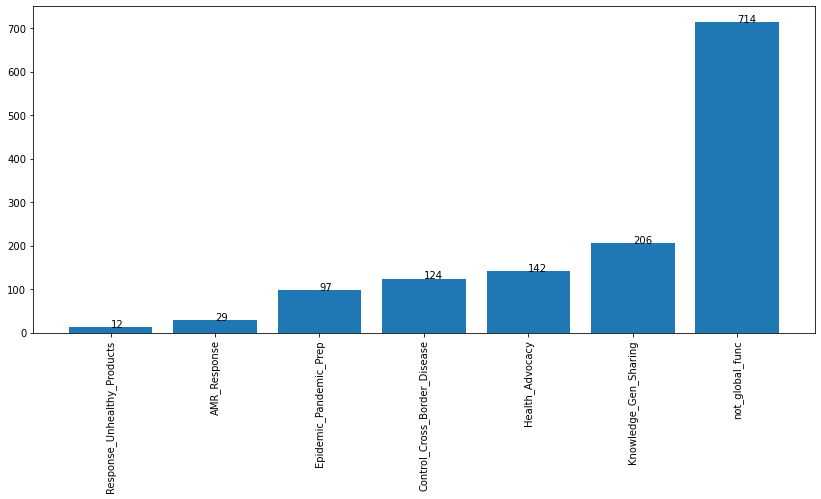

In [10]:
#plotting the observation cat
plt.figure(figsize=(14,6))
plt.bar(df_sorted["label_cat"], df_sorted["cat_size"])
plt.xticks(rotation=90)

for i, v in enumerate(df_sorted["cat_size"]):
    plt.text(i, v, str(v))

#we can see there is huge data imbalance between various categories. 
#Not a global function has a lot of data than the other categories
#This will be amjor problem when we run our model.
# There is very high probability that our model will become biased due to the large imbalance in the data

In [11]:
#checking the percentage of each categories
print("Percentage of Epidemic_Pandemic_Prep={}%".
      format(round(len(global_func[global_func["category"]=="Epidemic_Pandemic_Prep"])/(global_func.shape[0]),4)*100))
print("Percentage of Knowledge_Gen_Sharing={}%".
      format(round(len(global_func[global_func["category"]=="Knowledge_Gen_Sharing"])/(global_func.shape[0]),3)*100))
print("Percentage of not_global_func={}%".
      format(round(len(global_func[global_func["category"]=="not_global_func"])/(global_func.shape[0]),4)*100))
print("Percentage of Health_Advocacy={}%".
      format(round(len(global_func[global_func["category"]=="Health_Advocacy"])/(global_func.shape[0]),4)*100))
print("Percentage of Control_Cross_Border_Disease={}%".
      format(round(len(global_func[global_func["category"]=="Control_Cross_Border_Disease"])/(global_func.shape[0]),3)*100))
print("Percentage of AMR_Response={}%".
      format(round(len(global_func[global_func["category"]=="AMR_Response"])/(global_func.shape[0]),4)*100))
print("Percentage of Response_Unhealthy_Products={}%".
      format(round(len(global_func[global_func["category"]=="Response_Unhealthy_Products"])/(global_func.shape[0]),4)*100))


Percentage of Epidemic_Pandemic_Prep=7.33%
Percentage of Knowledge_Gen_Sharing=15.6%
Percentage of not_global_func=53.93%
Percentage of Health_Advocacy=10.73%
Percentage of Control_Cross_Border_Disease=9.4%
Percentage of AMR_Response=2.19%
Percentage of Response_Unhealthy_Products=0.91%


#### Features engineering



In [12]:
#creating feature for text message length
global_func["body_len"]=global_func["description"].apply(lambda x: len(x)-x.count(" "))
global_func.head()

,description,category,body_len
0,EBOLA EMERGENCY RESPONSE PROJECT. NA,Epidemic_Pandemic_Prep,32
1,AFCC2/RI-EAST AFRICA PUBLIC HEALTH LABORATORY ...,Knowledge_Gen_Sharing,61
2,AFCC2/RI-EAST AFRICA PUBLIC HEALTH LABORATORY ...,Knowledge_Gen_Sharing,61
3,AFCC2/RI-EAST AFRICA PUBLIC HEALTH LABORATORY ...,Knowledge_Gen_Sharing,61
4,AFCC2/RI-EAST AFRICA PUBLIC HEALTH LABORATORY ...,Knowledge_Gen_Sharing,61


In [13]:
#creating feature of number of sentences in the text
def count_sent(text):
    return len(nltk.sent_tokenize(text))

global_func["body_sent"]=global_func["description"].apply(lambda x: count_sent(x))

global_func.head()

,description,category,body_len,body_sent
0,EBOLA EMERGENCY RESPONSE PROJECT. NA,Epidemic_Pandemic_Prep,32,2
1,AFCC2/RI-EAST AFRICA PUBLIC HEALTH LABORATORY ...,Knowledge_Gen_Sharing,61,2
2,AFCC2/RI-EAST AFRICA PUBLIC HEALTH LABORATORY ...,Knowledge_Gen_Sharing,61,2
3,AFCC2/RI-EAST AFRICA PUBLIC HEALTH LABORATORY ...,Knowledge_Gen_Sharing,61,2
4,AFCC2/RI-EAST AFRICA PUBLIC HEALTH LABORATORY ...,Knowledge_Gen_Sharing,61,2


In [14]:
#creating feature for % of punctuation in the text message

def count_punt(text):
    count= sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text)-text.count(" ")), 3)*100

global_func["punct%"]=global_func["description"].apply(lambda x: count_punt(x))

global_func.head()

,description,category,body_len,body_sent,punct%
0,EBOLA EMERGENCY RESPONSE PROJECT. NA,Epidemic_Pandemic_Prep,32,2,3.1
1,AFCC2/RI-EAST AFRICA PUBLIC HEALTH LABORATORY ...,Knowledge_Gen_Sharing,61,2,4.9
2,AFCC2/RI-EAST AFRICA PUBLIC HEALTH LABORATORY ...,Knowledge_Gen_Sharing,61,2,4.9
3,AFCC2/RI-EAST AFRICA PUBLIC HEALTH LABORATORY ...,Knowledge_Gen_Sharing,61,2,4.9
4,AFCC2/RI-EAST AFRICA PUBLIC HEALTH LABORATORY ...,Knowledge_Gen_Sharing,61,2,4.9


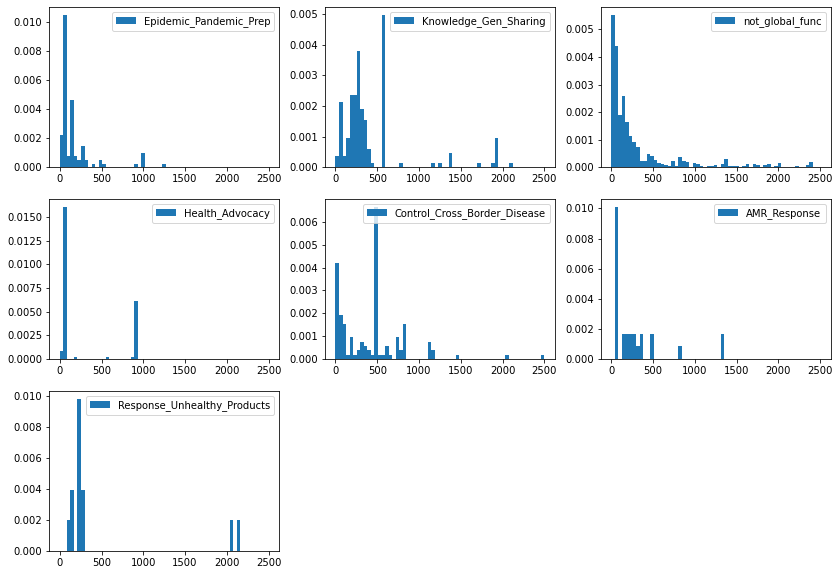

In [15]:
#lets evaluate the new features that we created and see if any of these need any transformation
#looking at text length
bins=np.linspace(0, 2500, 60)
plt.figure(figsize=(14,10))
plt.subplot(331)
plt.hist(global_func[global_func["category"]=="Epidemic_Pandemic_Prep"]["body_len"], bins, density=True, label="Epidemic_Pandemic_Prep")
plt.legend(loc="upper right")

plt.subplot(332)
plt.hist(global_func[global_func["category"]=="Knowledge_Gen_Sharing"]["body_len"], bins, density=True, label="Knowledge_Gen_Sharing")
plt.legend(loc="upper right")

plt.subplot(333)
plt.hist(global_func[global_func["category"]=="not_global_func"]["body_len"],  bins, density=True, label="not_global_func")
plt.legend(loc="upper right")

plt.subplot(334)
plt.hist(global_func[global_func["category"]=="Health_Advocacy"]["body_len"],  bins, density=True, label="Health_Advocacy")
plt.legend(loc="upper right")

plt.subplot(335)
plt.hist(global_func[global_func["category"]=="Control_Cross_Border_Disease"]["body_len"], bins, density=True, label="Control_Cross_Border_Disease")
plt.legend(loc="upper right")

plt.subplot(336)
plt.hist(global_func[global_func["category"]=="AMR_Response"]["body_len"], bins, density=True, label="AMR_Response")
plt.legend(loc="upper right")

plt.subplot(337)
plt.hist(global_func[global_func["category"]=="Response_Unhealthy_Products"]["body_len"], bins, density=True, label="Response_Unhealthy_Products")
plt.legend(loc="upper right")


plt.show();

It doesn't look like there is major difference in the length of text for each category. It almost similaryly distributed with a lot of text in each category with length below 500, and the a long tail. Since, we have a lot of data from "not_global_function" category so we can see a right skew very clearly.

Since there is this right skew, we will normalize this so that the model does not pay undue attention to these long text.

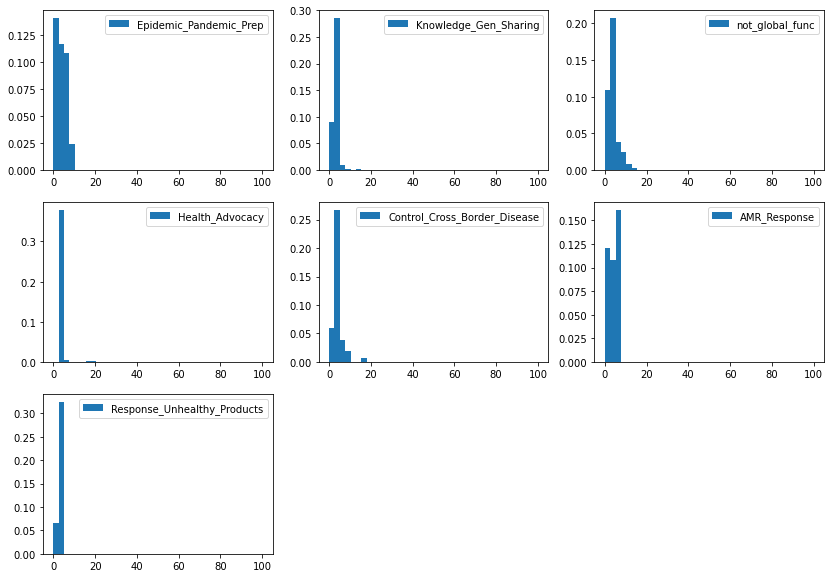

In [16]:
#looking at punctuation percentage
bins=np.linspace(0, 100, 40)
plt.figure(figsize=(14,10))

plt.subplot(331)
plt.hist(global_func[global_func["category"]=="Epidemic_Pandemic_Prep"]["punct%"], bins, density=True, label="Epidemic_Pandemic_Prep")
plt.legend(loc="upper right")

plt.subplot(332)
plt.hist(global_func[global_func["category"]=="Knowledge_Gen_Sharing"]["punct%"], bins, density=True, label="Knowledge_Gen_Sharing")
plt.legend(loc="upper right")

plt.subplot(333)
plt.hist(global_func[global_func["category"]=="not_global_func"]["punct%"],  bins, density=True, label="not_global_func")
plt.legend(loc="upper right")

plt.subplot(334)
plt.hist(global_func[global_func["category"]=="Health_Advocacy"]["punct%"],  bins, density=True, label="Health_Advocacy")
plt.legend(loc="upper right")

plt.subplot(335)
plt.hist(global_func[global_func["category"]=="Control_Cross_Border_Disease"]["punct%"], bins, density=True, label="Control_Cross_Border_Disease")
plt.legend(loc="upper right")

plt.subplot(336)
plt.hist(global_func[global_func["category"]=="AMR_Response"]["punct%"], bins, density=True, label="AMR_Response")
plt.legend(loc="upper right")

plt.subplot(337)
plt.hist(global_func[global_func["category"]=="Response_Unhealthy_Products"]["punct%"], bins, density=True, label="Response_Unhealthy_Products")
plt.legend(loc="upper right")


plt.show();

We can see from the above histogram pf punctuation that there is not much of a difference in the punctuation use among various categories. Also, here is not skew. So, no transoformation will be required for this feature. However, we will still leave this feature for model to learn something

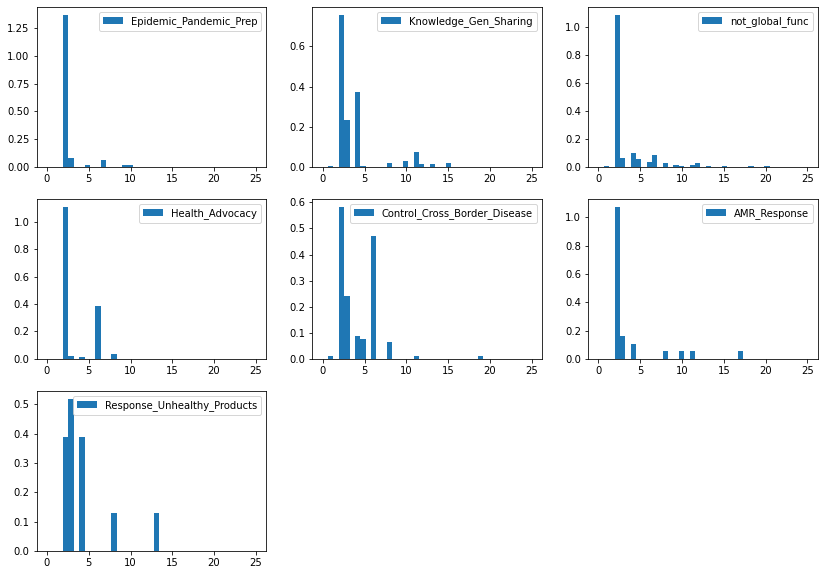

In [17]:
#looking at number of sentence

bins=np.linspace(0, 25, 40)
plt.figure(figsize=(14,10))

plt.subplot(331)
plt.hist(global_func[global_func["category"]=="Epidemic_Pandemic_Prep"]["body_sent"], bins, density=True, label="Epidemic_Pandemic_Prep")
plt.legend(loc="upper right")

plt.subplot(332)
plt.hist(global_func[global_func["category"]=="Knowledge_Gen_Sharing"]["body_sent"], bins, density=True, label="Knowledge_Gen_Sharing")
plt.legend(loc="upper right")

plt.subplot(333)
plt.hist(global_func[global_func["category"]=="not_global_func"]["body_sent"],  bins, density=True, label="not_global_func")
plt.legend(loc="upper right")

plt.subplot(334)
plt.hist(global_func[global_func["category"]=="Health_Advocacy"]["body_sent"],  bins, density=True, label="Health_Advocacy")
plt.legend(loc="upper right")

plt.subplot(335)
plt.hist(global_func[global_func["category"]=="Control_Cross_Border_Disease"]["body_sent"], bins, density=True, label="Control_Cross_Border_Disease")
plt.legend(loc="upper right")

plt.subplot(336)
plt.hist(global_func[global_func["category"]=="AMR_Response"]["body_sent"], bins, density=True, label="AMR_Response")
plt.legend(loc="upper right")

plt.subplot(337)
plt.hist(global_func[global_func["category"]=="Response_Unhealthy_Products"]["body_sent"], bins, density=True, label="Response_Unhealthy_Products")
plt.legend(loc="upper right")


plt.show();

There is right skew in the above plot as well. We also perform transformation on this feature as well.

#### Now lets look at which features might require transformation


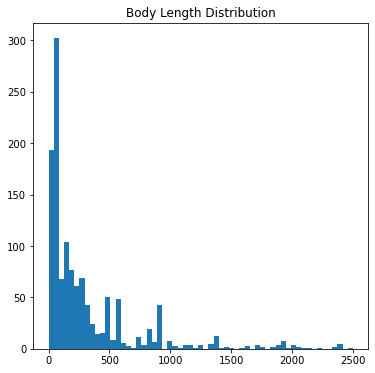

In [18]:
#looking at aggregated data histogram of the new features to see which are the best candidate for transformation
#looking at text length
bins=np.linspace(0, 2500, 60)
plt.figure(figsize=(6,6))

plt.hist(global_func["body_len"], bins)
plt.title("Body Length Distribution")
plt.show();


#crealy there is right skew in the data. So, we will transform this data so that the histogram looks like bell curve

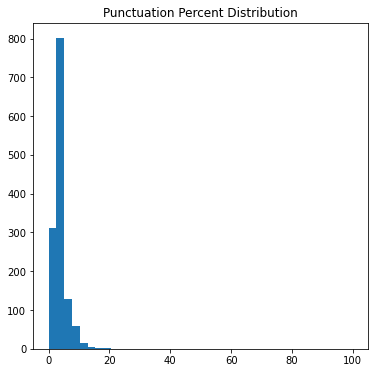

In [19]:
#looking at punctuation percentage
bins=np.linspace(0, 100, 40)
plt.figure(figsize=(6,6))

plt.hist(global_func["punct%"], bins)
plt.title("Punctuation Percent Distribution")
plt.show();

#there is no skew. So, we won't transfer this.

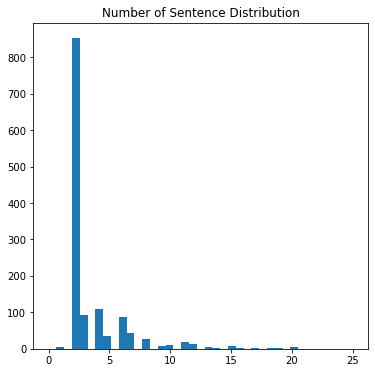

In [21]:
#looking at sentence length

bins=np.linspace(0, 25, 40)
plt.figure(figsize=(6,6))

plt.hist(global_func["body_sent"], bins)
plt.title("Number of Sentence Distribution")
plt.show();

#there is right skew. We will transfer this feature as well so that the data is concetrated around some central value.

#### Box-cox power transformation

##### We will use the box-cox power transformation to transform "body_len" and "body_sent" feature vectors



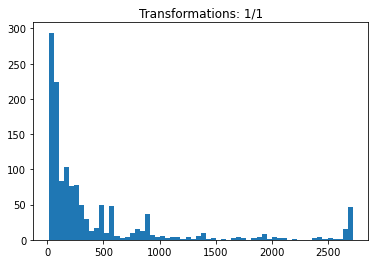

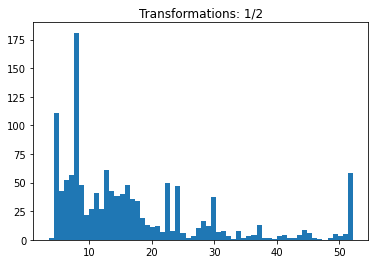

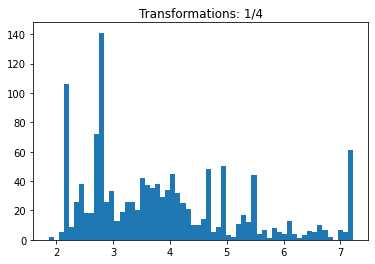

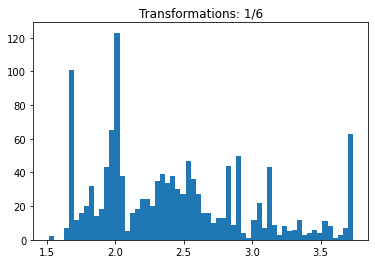

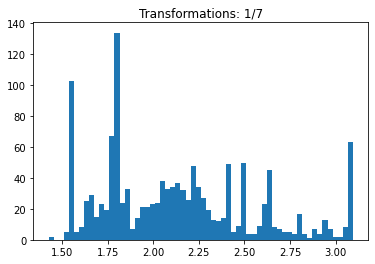

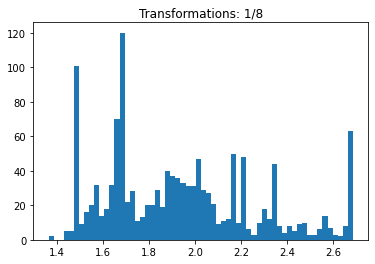

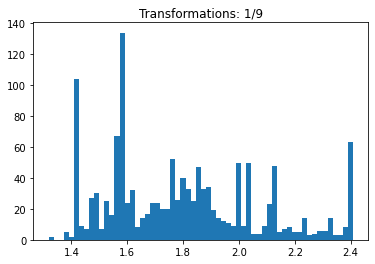

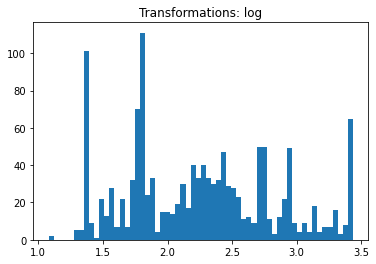

In [22]:
# checking different exponents on body len and printing the hist to see how the distribution changes

for i in [1,2,4,6,7, 8, 9]:
    plt.hist((global_func["body_len"])**(1/i), bins=60)
    plt.title("Transformations: 1/{}".format(str(i)))
    plt.show();
    
plt.hist(np.log10(global_func["body_len"]), bins=60)
plt.title("Transformations: log")
plt.show();

#after 6th power the histograms look very similar. However, the log transformation look better than than other powers

In [403]:
#applying logrithmic transformation on "body_len" column s
global_func["body_len"]=global_func["body_len"].apply(lambda x: np.log10(x))

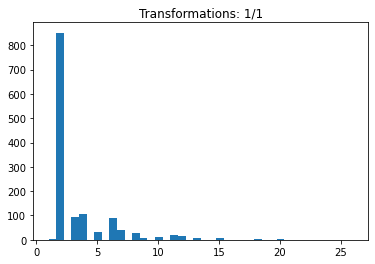

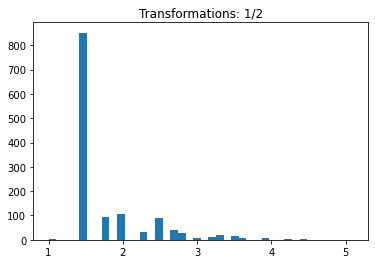

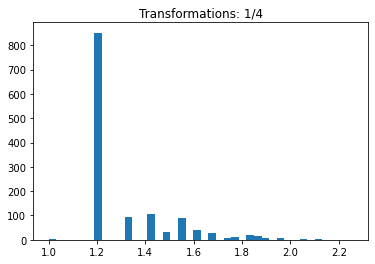

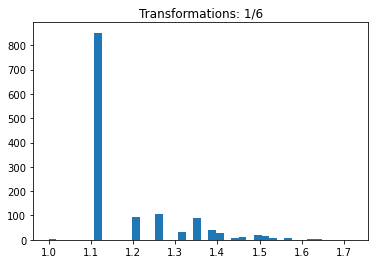

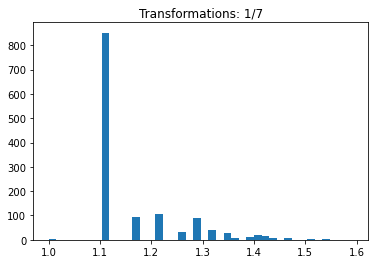

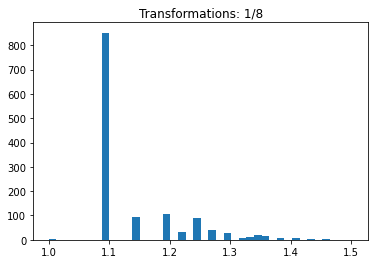

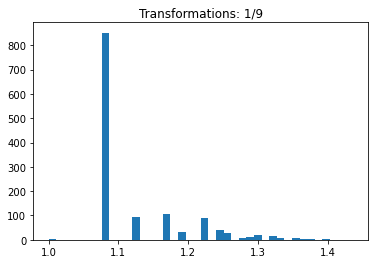

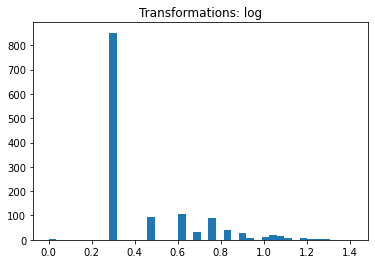

In [23]:
## checking different exponents on number of sentences and printing the hist to see how the distribution changes
for i in [1,2,4,6,7, 8, 9]:
    plt.hist((global_func["body_sent"])**(1/i), bins=40)
    plt.title("Transformations: 1/{}".format(str(i)))
    plt.show();
    
plt.hist(np.log10(global_func["body_sent"]), bins=40)
plt.title("Transformations: log")
plt.show();

In [24]:
#applying logrithmic transformation on "body_len" column s
global_func["body_sent"]=global_func["body_sent"].apply(lambda x: np.log10(x))

In [25]:
global_func.head()

,description,category,body_len,body_sent,punct%
0,EBOLA EMERGENCY RESPONSE PROJECT. NA,Epidemic_Pandemic_Prep,32,0.30103,3.1
1,AFCC2/RI-EAST AFRICA PUBLIC HEALTH LABORATORY ...,Knowledge_Gen_Sharing,61,0.30103,4.9
2,AFCC2/RI-EAST AFRICA PUBLIC HEALTH LABORATORY ...,Knowledge_Gen_Sharing,61,0.30103,4.9
3,AFCC2/RI-EAST AFRICA PUBLIC HEALTH LABORATORY ...,Knowledge_Gen_Sharing,61,0.30103,4.9
4,AFCC2/RI-EAST AFRICA PUBLIC HEALTH LABORATORY ...,Knowledge_Gen_Sharing,61,0.30103,4.9


### Now we will clean our data. This means we will do the following step:

1. First we remove the punctuations.
2. then we will remove the stopwords like the, a, etc.
3. Finally we will stem or lemmatize the work. We will explore both stemming and lemmatization.



In [26]:
#checking punctuations available in string package
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [27]:
#initializing the stopwords and stemmer and lemmetizer
stopwords=nltk.corpus.stopwords.words("English")
#ps=nltk.PorterStemmer()
wn=nltk.WordNetLemmatizer()

In [28]:
#creating the cleaning function
def clean_text(text):
    
    #removing punctuation
    clean_punct="".join([char for char in text if char not in string.punctuation])
    
    #spitting into token based on word end
    token=re.split("\W+",clean_punct)
    
    #decided to use lemmetizer instead of stemmer as lemmetizer provids better results and also understands language semantics
    clean_lemma= [wn.lemmatize(word.upper()) for word in token if word not in stopwords] 
    
    #removing "NA" token
    remove_na= [word for word in clean_lemma if word !="NA"]
    
    #returning the cleaned text
    return remove_na

<>:8: DeprecationWarning: invalid escape sequence \W
<>:8: DeprecationWarning: invalid escape sequence \W
C:\Users\sd282\AppData\Local\Temp/ipykernel_10000/4060127847.py:8: DeprecationWarning: invalid escape sequence \W
  token=re.split("\W+",clean_punct)


In [410]:
#applying the clean_text() function on the description column using lambda function
#global_func["descrip_clean"]=global_func["description"].apply(lambda x: clean_text(x))

### Vectorizing Raw Data 

#### Applying CountVectorizer

In [30]:
count_vect= CountVectorizer(analyzer=clean_text)
x_counts= count_vect.fit_transform(global_func["description"])
print(x_counts.shape)
print(count_vect.get_feature_names())

(1324, 6855)
['0', '000', '001', '002', '003', '005', '005NUTRITION', '0106', '02', '03', '035', '05', '08', '080', '0817', '1', '10', '100', '1000', '10000', '10000000', '1015', '1020FOLD', '10372', '10400', '1075000', '109', '11', '11000', '111', '11179', '1140', '115', '115000', '116', '12', '120', '1200', '120000', '12110', '1220152017', '1255', '1265', '127', '13', '131', '135', '14', '140', '141417', '14416', '1492017', '15', '150', '1500', '1520', '1535', '16', '160', '1617', '164', '17', '17000', '17025', '17100', '18', '185', '1858', '188', '19', '190', '1970S', '1981', '1995', '1ST', '1Y', '2', '20', '200', '2000', '2003', '2004', '2005', '200574010', '2006', '2007', '2008', '2009', '2010', '2010A', '2010B', '201112', '2012', '2013', '201317', '2014', '201415', '20142016', '2015', '201516', '20152018', '20152020', '20152030', '2015V', '2015WITH', '2016', '201617', '201620', '20162017', '20162018', '20162020', '2016A', '2016TCHAD', '2017', '201718', '201720', '20172018', '2017

In [31]:
#vectorizer outputs a sparse matrix. Lets take a look at the matrix
x_counts_df=pd.DataFrame(x_counts.toarray())

x_counts_df

#we can see below that the matrix is full of zeors. So, it is a sparese matrix. Each column is a unique word
#Each row is number of text description in our dataset.
#The column value will be other than zero if the unique word exist in the text 

,0,1,2,3,4,5,6,7,8,9,...,6845,6846,6847,6848,6849,6850,6851,6852,6853,6854
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1319,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1320,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1321,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1322,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0


In [32]:
# we can also see what words each column represent
x_counts_df.columns= count_vect.get_feature_names()

x_counts_df.head()

,0,000,001,002,003,005,005NUTRITION,0106,02,03,...,ZINC,ZONE,ZONES,ZOONOSES,ZOONOTIC,ÒAG,ÒGOVERNANCE,ÒWORKING,Û,ÛASIA
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
#not clear which text has ÒAG. So, checking which rowa/text have this word
x_counts_df[x_counts_df["ÒAG"]==1]

,0,000,001,002,003,005,005NUTRITION,0106,02,03,...,ZINC,ZONE,ZONES,ZOONOSES,ZOONOTIC,ÒAG,ÒGOVERNANCE,ÒWORKING,Û,ÛASIA
1238,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,1,0,0
1239,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,1,0,0
1240,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,1,0,0
1241,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,1,0,0


In [34]:
#extracting the text 1238 from description to see how word ÒAG is used
print(global_func.loc[1238, "description"])

AFRIKAGRUPPERNA FRAME 2017-2021. Framework agreement 2017-2021The current frame agreement between the Africa groups (AG) of Sweden and Sida runs from 2017-2021. Implementation is made by partner organizations in Angola, Mozambique, Namibia, South Africa and Zimbabwe. AG applies a rights based approach and works within four thematic areas; òGovernance of natural resourcesòFood sovereigntyòSRHR and HIV òWorking and living conditions. During the appraisal the following dialogue objectives was identified: òAG and its POs has strengthened capacity related to risk analysis and risk management at program and organization level.òAG has strengthened the integration of conflict sensitivity.òAG has adjusted and developed systems for internal control related to cooperation with new rights-oriented actors and networks have been developed.òSecuring and implementing the enhanced gender equality work at the organization and program level.òStrengthened capacity for monitoring and internal control at th

#### Applying tfi-df 

In [35]:
tfidf_vect=TfidfVectorizer(analyzer=clean_text)
x_tfidf=tfidf_vect.fit_transform(global_func["description"])
print(x_tfidf.shape)
print(tfidf_vect.get_feature_names())

(1324, 6855)
['0', '000', '001', '002', '003', '005', '005NUTRITION', '0106', '02', '03', '035', '05', '08', '080', '0817', '1', '10', '100', '1000', '10000', '10000000', '1015', '1020FOLD', '10372', '10400', '1075000', '109', '11', '11000', '111', '11179', '1140', '115', '115000', '116', '12', '120', '1200', '120000', '12110', '1220152017', '1255', '1265', '127', '13', '131', '135', '14', '140', '141417', '14416', '1492017', '15', '150', '1500', '1520', '1535', '16', '160', '1617', '164', '17', '17000', '17025', '17100', '18', '185', '1858', '188', '19', '190', '1970S', '1981', '1995', '1ST', '1Y', '2', '20', '200', '2000', '2003', '2004', '2005', '200574010', '2006', '2007', '2008', '2009', '2010', '2010A', '2010B', '201112', '2012', '2013', '201317', '2014', '201415', '20142016', '2015', '201516', '20152018', '20152020', '20152030', '2015V', '2015WITH', '2016', '201617', '201620', '20162017', '20162018', '20162020', '2016A', '2016TCHAD', '2017', '201718', '201720', '20172018', '2017

In [37]:
#the x_tfidf is sparse matrix. Lets look at it in data frame form
x_tfidf_df= pd.DataFrame(x_tfidf.toarray())

x_tfidf_df

#tfidf is very similar to count vectorizer. The matrix is full of zeros. Each column represents a word
#And which ever text (rows) the word comes we have the tfidf calculated. The values of tfidf will be different from 1.

,0,1,2,3,4,5,6,7,8,9,...,6845,6846,6847,6848,6849,6850,6851,6852,6853,6854
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1319,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
1320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
1321,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
1322,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.27776,0.0,0.0,0.0,0.0,0.0


In [38]:
# lets change the name of coulmns from number to actual words which these coulmns represent
x_tfidf_df.columns= tfidf_vect.get_feature_names()

x_tfidf_df

,0,000,001,002,003,005,005NUTRITION,0106,02,03,...,ZINC,ZONE,ZONES,ZOONOSES,ZOONOTIC,ÒAG,ÒGOVERNANCE,ÒWORKING,Û,ÛASIA
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1319,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
1320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
1321,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
1322,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.27776,0.0,0.0,0.0,0.0,0.0


#### Building machine learning classifier

In [39]:
#concatenating all  the features
x_features= pd.concat([global_func["body_len"], global_func["body_sent"], global_func["punct%"],pd.DataFrame(x_counts.toarray())],
                      axis=1)

x_features

,body_len,body_sent,punct%,0,1,2,3,4,5,6,...,6845,6846,6847,6848,6849,6850,6851,6852,6853,6854
0,32,0.301030,3.1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,61,0.301030,4.9,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,61,0.301030,4.9,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,61,0.301030,4.9,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,61,0.301030,4.9,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1319,356,0.477121,2.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1320,300,0.477121,2.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1321,314,0.301030,2.2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1322,314,0.301030,1.6,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0


#### Exploring Random Forest Classifier through Cross-Validation to check how our model does before running it on a separate holdout set

In [40]:
#splitting the data into train and test set
X_train, X_test, y_train, y_test=train_test_split(x_features, global_func["category"], test_size=0.2,shuffle=True)

In [41]:
#instantiating the classifier
rf = RandomForestClassifier (n_estimators=50, max_depth=200, n_jobs = -1)
# generate your cross-validation prediction with 10 fold Stratified sampling
y_pred=cross_val_predict(rf, X_train, y_train, cv=5, n_jobs=-1)
y_pred.shape

(1059,)

In [42]:
#printing the classification result
print(classification_report(y_train, y_pred))

                              precision    recall  f1-score   support

                AMR_Response       0.92      0.55      0.69        22
Control_Cross_Border_Disease       0.97      0.79      0.87       108
      Epidemic_Pandemic_Prep       1.00      0.75      0.85        75
             Health_Advocacy       0.99      0.94      0.96       114
       Knowledge_Gen_Sharing       0.94      0.78      0.85       163
 Response_Unhealthy_Products       1.00      0.50      0.67        10
             not_global_func       0.85      0.99      0.92       567

                    accuracy                           0.90      1059
                   macro avg       0.95      0.75      0.83      1059
                weighted avg       0.91      0.90      0.89      1059



In [455]:
#creating confusion matrix
confusion_matrix(list(y_train), list(y_pred))

array([[ 18,   0,   0,   0,   1,   0,   7],
       [  0,  72,   0,   0,   1,   0,  26],
       [  0,   0,  50,   0,   1,   0,  19],
       [  0,   0,   0, 108,   0,   0,   6],
       [  0,   0,   0,   0, 139,   0,  28],
       [  0,   1,   0,   0,   1,   4,   3],
       [  1,   0,   0,   0,  10,   0, 563]], dtype=int64)

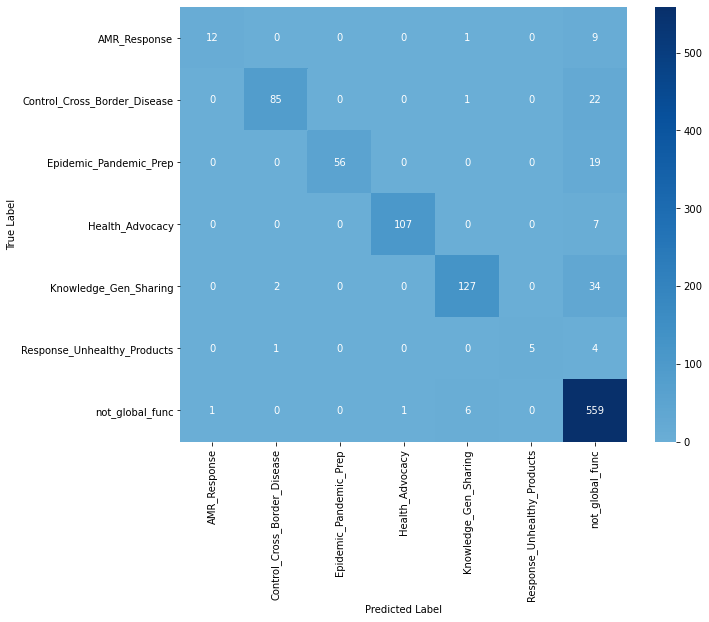

In [43]:
#creating confusion matrix heatmap
conf_mat_rf=confusion_matrix(list(y_train),list(y_pred))
conf_mat_df_rf= pd.DataFrame(conf_mat_rf,
                     index = ["AMR_Response", "Control_Cross_Border_Disease", "Epidemic_Pandemic_Prep", 
                             "Health_Advocacy", "Knowledge_Gen_Sharing", "Response_Unhealthy_Products", 
                             "not_global_func"], 
                     columns = ["AMR_Response", "Control_Cross_Border_Disease", "Epidemic_Pandemic_Prep", 
                             "Health_Advocacy", "Knowledge_Gen_Sharing", "Response_Unhealthy_Products", 
                              "not_global_func"])

plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat_df_rf, annot=True, cmap="Blues", center=0, fmt='g')          
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

#### Applying the classifier on Holdout Test set (Train and Test set separately)

In [83]:
#creating a train and test set
X_train, X_test, y_train, y_test=train_test_split(x_features, global_func["category"], test_size=0.2,shuffle=True)

#instantiating the model and fitting it on the train set
rf=RandomForestClassifier(n_estimators=150, max_depth=None)

#fitting the model on training data
rf_model=rf.fit(X_train, y_train)

In [84]:
#most important list of features tht random forest uses for learning
sorted(zip(rf_model.feature_importances_, X_train.columns), reverse=True)[0:10]

#our created features are in top 10 importance

[(0.019836279760887744, 459),
 (0.01966948614199316, 1449),
 (0.01943809305476125, 'body_len'),
 (0.018705886104898418, 3667),
 (0.01765234077709926, 528),
 (0.01673312964405877, 6354),
 (0.013793877928789087, 'punct%'),
 (0.013217185469558851, 2604),
 (0.011401851560248364, 5403),
 (0.011010337569549366, 2230)]

In [85]:
#predicting the categories using the trained model on test set 
y_pred=rf_model.predict(X_test)

#printing classification results
print(classification_report(y_test, y_pred)) 

                              precision    recall  f1-score   support

                AMR_Response       1.00      0.80      0.89         5
Control_Cross_Border_Disease       0.96      0.96      0.96        24
      Epidemic_Pandemic_Prep       1.00      0.77      0.87        30
             Health_Advocacy       1.00      0.94      0.97        33
       Knowledge_Gen_Sharing       0.96      0.68      0.79        34
 Response_Unhealthy_Products       1.00      1.00      1.00         2
             not_global_func       0.87      0.99      0.93       137

                    accuracy                           0.91       265
                   macro avg       0.97      0.88      0.91       265
                weighted avg       0.92      0.91      0.91       265



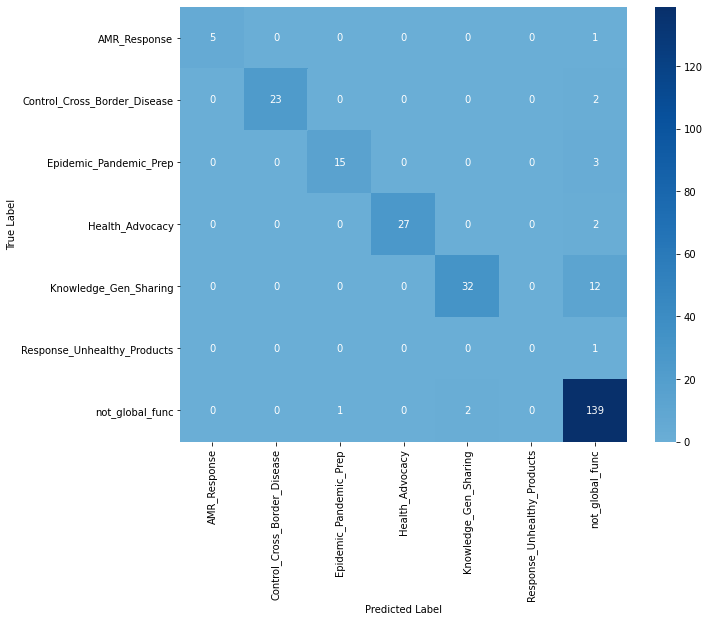

In [82]:
#creating confusion matrix heatmap
conf_mat_rf=confusion_matrix(list(y_test),list(y_pred))
conf_mat_df_rf= pd.DataFrame(conf_mat_rf,
                     index = ["AMR_Response", "Control_Cross_Border_Disease", "Epidemic_Pandemic_Prep", 
                             "Health_Advocacy", "Knowledge_Gen_Sharing", "Response_Unhealthy_Products", 
                             "not_global_func"], 
                     columns = ["AMR_Response", "Control_Cross_Border_Disease", "Epidemic_Pandemic_Prep", 
                             "Health_Advocacy", "Knowledge_Gen_Sharing", "Response_Unhealthy_Products", 
                              "not_global_func"])

plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat_df_rf, annot=True, cmap="Blues", center=0, fmt='g')          
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

From the above heatmap, we can see there are 23 misclassifications. Most of the misclassification are assigned to "not_global_fuction" category. Imbalance in our dataset could be one reason. Due to disproportional large number of data in this category in comparision to other categories cases our model to miscalssify into this category.

In [114]:
#checking which which predictions do not match to actual category, and then subsetting the X_test data set based on this.
X_test[y_test!=y_pred]

#However, this X_test data frame is a vectorized data frame where we have converted text to numbers for coputer to understand.
#Therefore, for humans to understand which description were misclassified, we will used the undex from this data frame,
#and subset the global_func dataframe.

,body_len,body_sent,punct%,0,1,2,3,4,5,6,...,6845,6846,6847,6848,6849,6850,6851,6852,6853,6854
1131,403,0.477121,4.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
991,154,0.301030,1.3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
357,103,0.301030,1.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1319,356,0.477121,2.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
956,268,0.301030,2.2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1146,222,0.301030,0.5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1125,197,0.301030,3.6,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1137,239,0.301030,3.8,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
393,298,0.477121,2.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
364,74,0.301030,1.4,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [178]:
#extracting the index numbers from the X_test which have been misclassified
index_list=X_test[y_test!=y_pred].index


#using the index extracted from X_test, we subset the original global_func data frame
global_func_misclass=global_func.iloc[index_list]

#resetting the index, and getting the index to start from 0, and creating a separate coulmn for oroginal index
global_func_misclass=global_func_misclass.reset_index()

#printing the global_func misclass data frame
global_func_misclass

,index,description,category,body_len,body_sent,punct%
0,1131,ENVISION. ENVISION is a five-year project aime...,Knowledge_Gen_Sharing,403,0.477121,4.0
1,991,DISTRIBUTION OF A HANDHELD DEVICE THAT AUTHENT...,Knowledge_Gen_Sharing,154,0.301030,1.3
2,357,PARTNERSHIP FOR CONTAINMENT OF ARTEMISININ RES...,Control_Cross_Border_Disease,103,0.301030,1.0
3,1319,DEVELOPMENT OF A NEW TOOL FOR MALARIA MOSQUITO...,Knowledge_Gen_Sharing,356,0.477121,2.0
4,956,INNOVATION FUNDING IN THE NEW L-NDER. Developm...,not_global_func,268,0.301030,2.2
5,1146,EAC REGIONAL NETWORK OF REFERENCE LABORATO...,Epidemic_Pandemic_Prep,222,0.301030,0.5
6,1125,ENSURING PEOPLE'S HEALTH RIGHTS THROUGH EVIDEN...,Health_Advocacy,197,0.301030,3.6
7,1137,"FUNDING FOR SCIENTIST EXCHANGES, GRANTS. ERA-N...",Knowledge_Gen_Sharing,239,0.301030,3.8
8,393,TACKLING THE STRUCTURAL DRIVERS OF THE HIV EPI...,Knowledge_Gen_Sharing,298,0.477121,2.0
9,364,PARTNERSHIP FOR RESEARCH AND CAPACITY BUILDING...,Epidemic_Pandemic_Prep,74,0.301030,1.4


In [188]:
#subsetting the values from y_pred which it wrongly predicts
y_pred_misclass=pd.DataFrame(y_pred[y_test!=y_pred])

#concatenating the the y_pred_misclass with the global_func_misclass data frame
global_func_mispred=pd.concat([global_func_misclass, y_pred_misclass], axis=1)

#renaming the misclassification prediction column
global_func_mispred=global_func_mispred.rename(columns={0:"class_pred"})

#creating the data frame with only the columns we are interedted in 
global_func_mispred=global_func_mispred[["index", "description", "category", "class_pred"]] 

#printing the data frame
global_func_mispred

,index,description,category,class_pred
0,1131,ENVISION. ENVISION is a five-year project aime...,Knowledge_Gen_Sharing,not_global_func
1,991,DISTRIBUTION OF A HANDHELD DEVICE THAT AUTHENT...,Knowledge_Gen_Sharing,not_global_func
2,357,PARTNERSHIP FOR CONTAINMENT OF ARTEMISININ RES...,Control_Cross_Border_Disease,not_global_func
3,1319,DEVELOPMENT OF A NEW TOOL FOR MALARIA MOSQUITO...,Knowledge_Gen_Sharing,Control_Cross_Border_Disease
4,956,INNOVATION FUNDING IN THE NEW L-NDER. Developm...,not_global_func,Knowledge_Gen_Sharing
5,1146,EAC REGIONAL NETWORK OF REFERENCE LABORATO...,Epidemic_Pandemic_Prep,not_global_func
6,1125,ENSURING PEOPLE'S HEALTH RIGHTS THROUGH EVIDEN...,Health_Advocacy,not_global_func
7,1137,"FUNDING FOR SCIENTIST EXCHANGES, GRANTS. ERA-N...",Knowledge_Gen_Sharing,not_global_func
8,393,TACKLING THE STRUCTURAL DRIVERS OF THE HIV EPI...,Knowledge_Gen_Sharing,not_global_func
9,364,PARTNERSHIP FOR RESEARCH AND CAPACITY BUILDING...,Epidemic_Pandemic_Prep,not_global_func


In the above table we can see that most of the prediction are misclassified as "not a global function" (column "class_pred").